
# TERM PAPER TECH2 Fall, 2025

Candidate number:
- 	36
-   44
-   66





### libraries used


In [119]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Part 1 — Reading in the data


In [120]:
def importCSV(folderLocation, startYear, endYear, sep=";", ):
    """
    Function to import multiple CSV files from a specified folder location
    for a range of years and concatenate them into a single DataFrame.

    Parameters:
    - folderLocation: The location of the folder containing the CSV files.
    - startYear: The starting year for the data.
    - endYear: The ending year for the data.
    - sep: The separator used in the CSV files (default is ";").

    Returns:
    - A DataFrame containing data from all specified CSV files.

    raises:
    - FileNotFoundError: If a specified CSV file does not exist.
    """
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    all_dfs = []

    for month in months:
        for year in range(startYear, endYear + 1):
            csv_string = f"{folderLocation}/SCE-{month}-{year}.csv" 
            try:
                csv_file = pd.read_csv(csv_string, sep=sep)
                all_dfs.append(csv_file)
            except FileNotFoundError:   
                print(f"Filen {csv_string} finnes ikke.")

    return  pd.concat(all_dfs)
df = importCSV("data/", 2014, 2024)

In [121]:
cpi = pd.read_csv("data/CPI.csv")
cpi

,DATE,CPI
0,1947-01-01,21.5
1,1947-02-01,21.6
2,1947-03-01,22.0
3,1947-04-01,22.0
4,1947-05-01,22.0
...,...,...
939,2025-04-01,320.3
940,2025-05-01,320.6
941,2025-06-01,321.5
942,2025-07-01,322.1


In [122]:
def df_stats(df):
    """
    Function to print basic statistics about the dataframe 
    """
    unique_persons = df["userid"].nunique()

    print(f"Unique persons: {unique_persons}")
    print(f"Number of rows: {df.shape[0]}")

    print(f"Number of unique survey waves: {df['wid'].nunique()}")

    earliest_date = df['date'].min()
    print(f"Earliest date: {earliest_date}")

    latest_date = df['date'].max()
    print(f"Latest date: {latest_date}")

df_stats(df)


Unique persons: 21666
Number of rows: 165924
Number of unique survey waves: 132
Earliest date: 2014-01-02
Latest date: 2024-12-31


## Task 2  — Data pre-processing

### 2.1 - filling missing numeracy variables

In [123]:


'''
# 0) Basic hygiene
df = df.copy()
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# --- Helpers for neat reporting ---
def sample_stats(_df, title="Sample stats"):
    n_obs = len(_df)
    n_indiv = _df["userid"].nunique() if "userid" in _df.columns else np.nan
    n_waves = _df["date"].dt.to_period("M").nunique() if "date" in _df.columns else np.nan
    dmin = _df["date"].min() if "date" in _df.columns else None
    dmax = _df["date"].max() if "date" in _df.columns else None
    print(f"\n== {title} ==")
    print(f"Observations: {n_obs:,}")
    print(f"Unique individuals: {n_indiv:,}" if pd.notna(n_indiv) else "Unique individuals: N/A")
    print(f"Survey waves (months): {n_waves:,}" if pd.notna(n_waves) else "Survey waves (months): N/A")
    if dmin is not None:
        print(f"Date range: {dmin.strftime('%Y-%m')} to {dmax.strftime('%Y-%m')}")

# Snapshot before cleaning
sample_stats(df, "Before cleaning")
'''

# 1) Forward-fill numeracy (per individual) from the first observation
#    The term paper says: forward-fill the *_correct variables only (asked at first entry).

def forward_fill_numeracy(df, col_names):
    """
    Forward-fills numeracy columns (specified in col_names) per individual
    using the first observed value for each user.

    Parameters:
    - df: DataFrame containing the data.
    - col_names: List of column names to forward-fill.

    returns:
    - DataFrame with forward-filled numeracy columns.

    If None, no columns are forward-filled.
    """

    # Check if col_names is provided
    if not col_names:
        print("No changes were made as no numeracy columns were found.")
        return df

    # Forward-fill the specified columns and return the updated DataFrame
    first_vals = df.groupby("userid", dropna=False)[col_names].transform("first")
    df[col_names] = df[col_names].fillna(first_vals)
    return df

num_cols = [c for c in df.columns if c.startswith("num_lit_") and c.endswith("_correct")]
df = forward_filled_df = forward_fill_numeracy(df, num_cols)
# df.info()

### 2.2 Drop observations


In [124]:
 #2) Drop rows with missing required fields
#    Demographics: female (indicator), age, educ
#    Expectations: inflation, house_price_change, prob_stocks_up
#    Numeracy: all *_correct columns (after forward fill)
required_cols = ["female", "age", "educ", "inflation", "house_price_change", "prob_stocks_up"] + num_cols
required_cols = [c for c in required_cols if c in df.columns]  # keep only those that exist

before = len(df)
df = df.dropna(subset=required_cols)
dropped_missing = before - len(df)
print(f"\nDropped rows with missing required values: {dropped_missing:,}")



Dropped rows with missing required values: 28,348


### 2.3 Drop Outliers

In [125]:
#3) Drop outliers using 0.1th and 99.9th percentiles for each expectations variable
exp_vars = [c for c in ["inflation", "house_price_change", "prob_stocks_up"] if c in df.columns]
dropped_outliers_total = 0
for col in exp_vars:
    q_low = df[col].quantile(0.001)
    q_high = df[col].quantile(0.999)
    mask_keep = (q_low <= df[col]) & (df[col] <= q_high)
    dropped = (~mask_keep).sum()
    df = df.loc[mask_keep].copy()
    dropped_outliers_total += int(dropped)
    print(f"Dropped outliers for {col}: {int(dropped):,} "
          f"(kept [{q_low:.3f}, {q_high:.3f}])")

print(f"Total outliers dropped: {dropped_outliers_total:,}")


Dropped outliers for inflation: 119 (kept [-75.000, 100.000])
Dropped outliers for house_price_change: 179 (kept [-50.000, 100.000])
Dropped outliers for prob_stocks_up: 0 (kept [0.000, 100.000])
Total outliers dropped: 298


### 2.4 creating new column

In [126]:

def add_threshold_flag(df, col_name, new_col_name, threshold):
    """
    Adds a binary column to the DataFrame indicating whether the values in col_name exceed the threshold.

    Parameters:
    - df: DataFrame containing the data.
    - col_name: The name of the column to evaluate.
    - new_col_name: The name of the new binary column to create.
    - threshold: The threshold value for comparison.

    returns:
    - DataFrame with the new binary column added.
    """
    if col_name in df.columns:
        df[new_col_name] = (df[col_name] > threshold).astype(int)

    return df




In [127]:
# 4) Create 'college' = 1 if educ >= 4 (Bachelor’s or higher), else 0
#    (educ is ordinal: 1=no HS/GED, 2=HS/GED, 3=some college/assoc., 4=bachelor’s+)
df = add_threshold_flag(df, "educ", "college", 3)

### 2.5 

In [128]:
#Solution to task 2.5?

# 5) Sum correct numeracy answers per row and create 'num_lit_high'

def num_correct_stats(df, arr_cols_name):
    """
    Calculates total correct numeracy answers per respondent,
    prints distribution of scores, and creates 'num_lit_high'.
    Returns the updated DataFrame and the median number of correct answers.
    """
    if not arr_cols_name:
        med = None
        return df, med

    # Only run if numeracy columns exist
    # Sum correct answers per row
    df["num_correct"] = df[arr_cols_name].sum(axis=1)

    # Use only one observation per user to compute distribution
    df_unique = df.drop_duplicates(subset='userid').copy()
    unique_users = df_unique.shape[0]

    # Print percentage for each possible score
    counts = df_unique["num_correct"].value_counts().sort_index()
    for score, count in counts.items():
        percent = count / unique_users
        print(f"{percent:.2%} have {score} correct answers")


    return df






In [129]:
# 5) Sum correct numeracy answers per row and create 'num_lit_high'
df= num_correct_stats(df, num_cols)
med = df["num_correct"].median()
df = add_threshold_flag(df, "num_correct", "num_lit_high", med)

0.14% have 0.0 correct answers
0.73% have 1.0 correct answers
2.40% have 2.0 correct answers
5.71% have 3.0 correct answers
10.51% have 4.0 correct answers
16.94% have 5.0 correct answers
27.41% have 6.0 correct answers
36.17% have 7.0 correct answers


In [130]:
# 6) Final sample stats (same structure as Part 1)
df_stats(df)

Unique persons: 17701
Number of rows: 137278
Number of unique survey waves: 117
Earliest date: 2015-04-02
Latest date: 2024-12-31


## Part 3 — Average expectations by group



### 3.0 general function 


In [131]:
def GroupIndex(df, GroupCol): 
    """
    
    """
    df1 = df.groupby(GroupCol)[["inflation", "house_price_change", "prob_stocks_up"]].mean().reset_index()
    df1 = df1.set_index(GroupCol)
    return df1


In [132]:
def barChart(df, label1, label2, grouplabel):
    """
    Creates a figure with three bar charts comparing two groups.
    
    Parameters:
    - df: DataFrame with expectations data
    - label1, label2: Labels for the two groups
    - grouplabel: Label for x-axis

    Returns: fig, (ax1, ax2, ax3)
    """
    if df.shape[0] != 2:
        raise ValueError("DataFrame must have exactly two rows (one per group).")

    # Create figure and axes in one go
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), 
                            height_ratios=[1, 1.2], 
                            gridspec_kw={'hspace': 0.35, 'wspace': 0.3})
    
    # Extract data once
    vals = df.values
    x = np.arange(2)
    width = 0.6
    colors = ["#0A54CC", "#D25B16"]
    
    # Common settings for all plots
    titles = df.columns
    ylabels = ["% increase", "% increase", "% probability"]
    
    # Plot first two panels
    for i, ax in enumerate(axes[0]):
        ax.bar(x, vals[:, i], width, color=colors)
        ax.set(title=titles[i],
               xlabel=grouplabel,
               ylabel=ylabels[i],
               xticks=x,
               xticklabels=[label1, label2])
        ax.legend([label1, label2], frameon=False)
        
    # Plot third panel
    ax3 = axes[1, 0]
    ax3.bar(x, vals[:, 2], width, color=colors)
    ax3.set(title=titles[2],
            xlabel=grouplabel,
            ylabel=ylabels[2],
            xticks=x,
            xticklabels=[label1, label2])
    ax3.legend([label1, label2], frameon=False)
    
    # Remove unused subplot
    fig.delaxes(axes[1, 1])

    fig.suptitle("Difference in expectations between groups", y=0.95)
    plt.show()
    
    return fig, (axes[0, 0], axes[0, 1], axes[1, 0])


### 3.1 Males vs. females

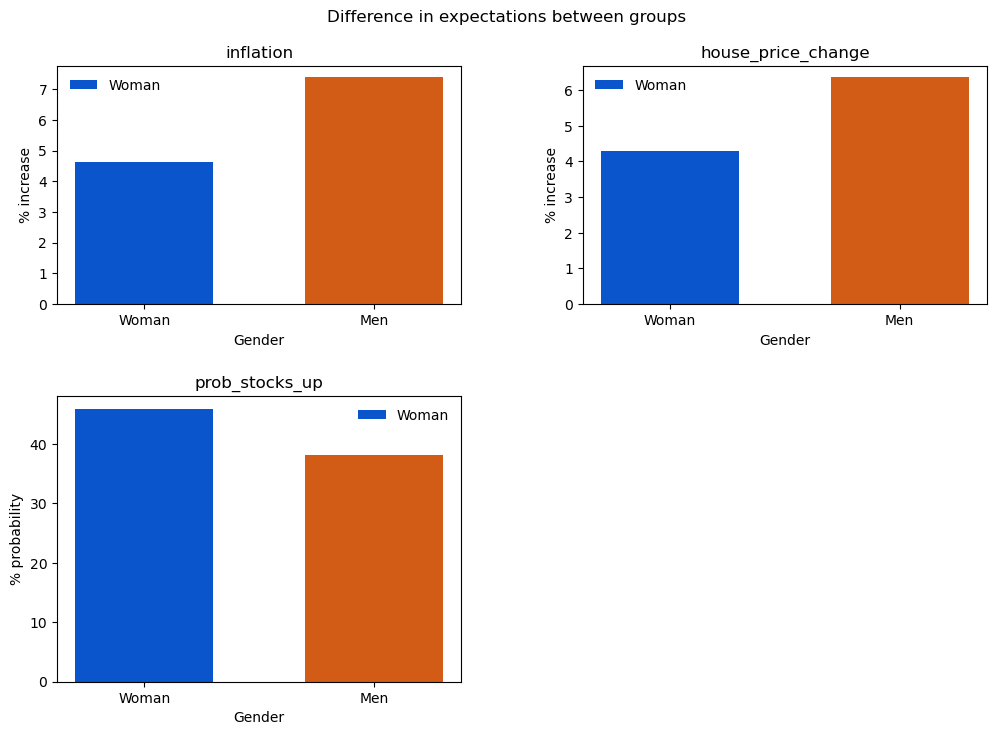

(<Figure size 1200x800 with 3 Axes>,
 (<Axes: title={'center': 'inflation'}, xlabel='Gender', ylabel='% increase'>,
  <Axes: title={'center': 'house_price_change'}, xlabel='Gender', ylabel='% increase'>,
  <Axes: title={'center': 'prob_stocks_up'}, xlabel='Gender', ylabel='% probability'>))

In [133]:
df1 = GroupIndex(df, "female")
barChart(df1, "Woman", "Men", "Gender")

### 3.2 Non-college vs. college


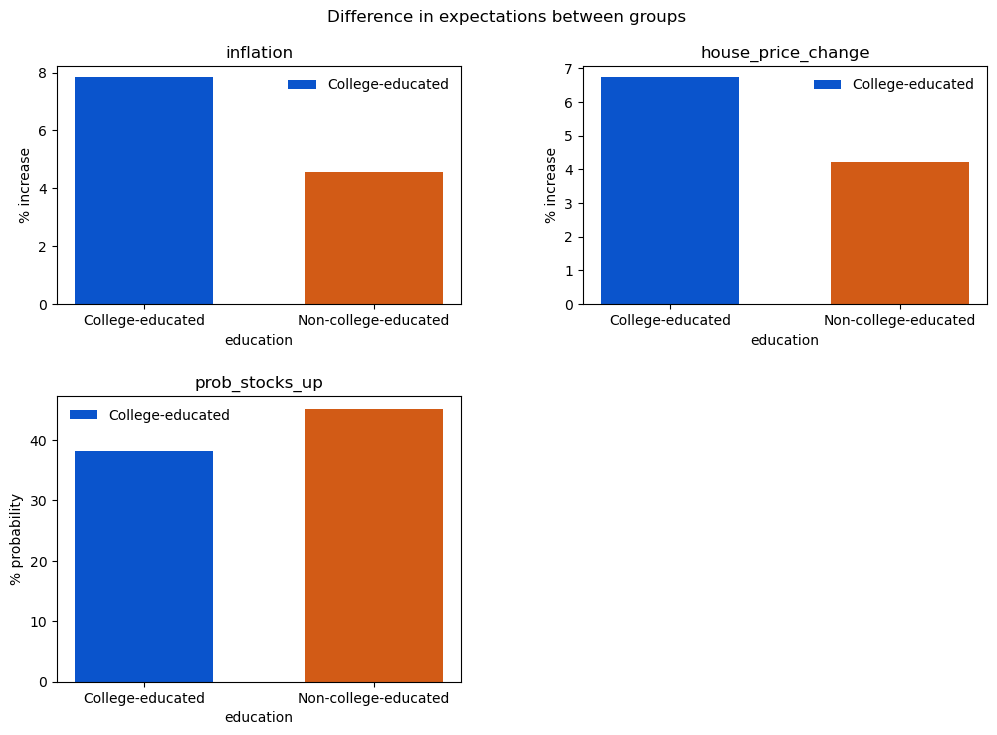

(<Figure size 1200x800 with 3 Axes>,
 (<Axes: title={'center': 'inflation'}, xlabel='education', ylabel='% increase'>,
  <Axes: title={'center': 'house_price_change'}, xlabel='education', ylabel='% increase'>,
  <Axes: title={'center': 'prob_stocks_up'}, xlabel='education', ylabel='% probability'>))

In [134]:
df2 = GroupIndex(df, "college")
barChart(df2, "College-educated", "Non-college-educated", "education")

### 3.3  Low vs. high numeracy


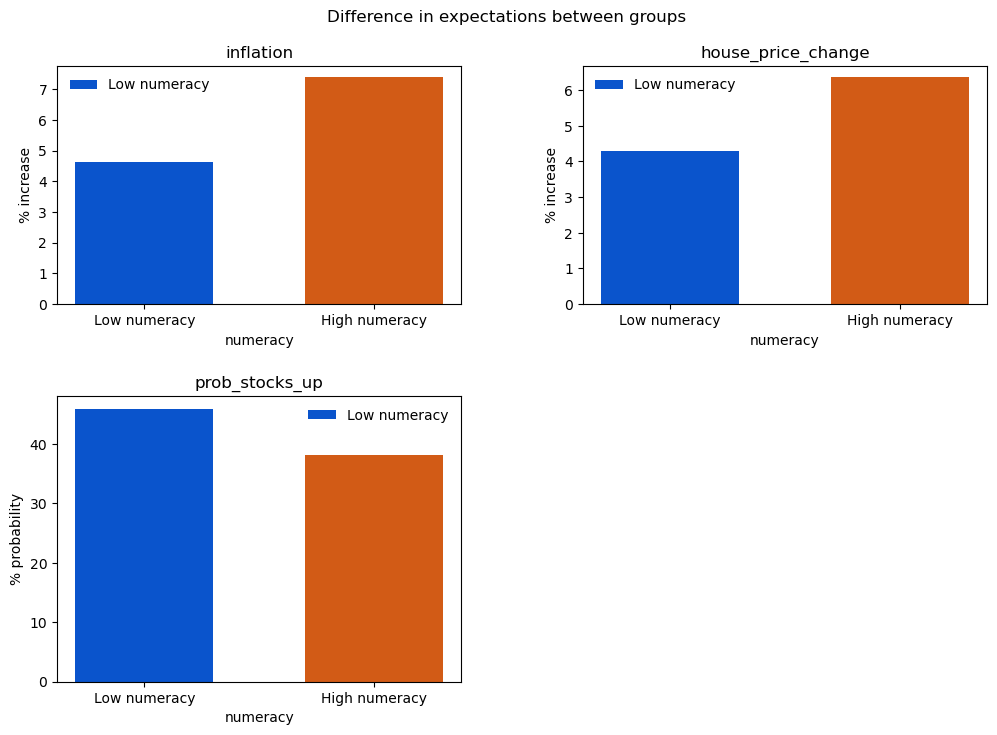

(<Figure size 1200x800 with 3 Axes>,
 (<Axes: title={'center': 'inflation'}, xlabel='numeracy', ylabel='% increase'>,
  <Axes: title={'center': 'house_price_change'}, xlabel='numeracy', ylabel='% increase'>,
  <Axes: title={'center': 'prob_stocks_up'}, xlabel='numeracy', ylabel='% probability'>))

In [135]:
df3 = GroupIndex(df, "female")
barChart(df3, "Low numeracy", "High numeracy", "numeracy")

## Part 4 — Expectation dynamics by group




### 4.1 monthly averages

This section calculates the monthly averages of inflation, house prices, and stock market values for womman and men. 

In [136]:
def monthly_group_means(df, group_col, date_col="date"):
    """
    Collapse to monthly averages of expectations for each group value.
    Returns a monthly index DataFrame with columns as group values.
    """
    use = df[[date_col, group_col, "inflation", "house_price_change", "prob_stocks_up"]].copy()
    use[date_col] = pd.to_datetime(use[date_col], errors="coerce")
    use = use.dropna(subset=[date_col])

    # monthly key
    use["month"] = use[date_col].dt.to_period("M").dt.to_timestamp()

    # compute monthly means by group
    gb = (use
          .groupby(["month", group_col], as_index=False)[["inflation", "house_price_change", "prob_stocks_up"]]
          .mean())

    # pivot so each group is a column
    infl = gb.pivot(index="month", columns=group_col, values="inflation")
    house = gb.pivot(index="month", columns=group_col, values="house_price_change")
    stock = gb.pivot(index="month", columns=group_col, values="prob_stocks_up")

    # limit to 2015–2024 per instructions
    infl = infl.loc["2015-01":"2024-12"]
    house = house.loc["2015-01":"2024-12"]
    stock = stock.loc["2015-01":"2024-12"]

    return infl, house, stock

### 4.2 - Plotting expected dynamics


In [137]:
def plot_expectation_dynamics(infl, house, stock, group_labels=None, title_suffix=""):
    """
    Draws three vertically stacked panels with two lines per panel (columns of the input frames).
    group_labels: optional dict {group_value: "Label"} to prettify legends.
    """
    # Major events (exact dates per assignment)
    events = [
        ("2016-11-08", "Trump elected (1st)"),
        ("2020-02-01", "COVID global"),
        ("2020-11-03", "Biden elected"),
        ("2022-02-24", "Russia invades Ukraine"),
        ("2023-10-03", "Jon Fosse Nobel"),
        ("2024-11-05", "Trump elected (2nd)"),
    ]  # 

    fig, axes = plt.subplots(3, 1, figsize=(9, 7), sharex=True)
    panels = [
        (infl, "Expected inflation (12m ahead, %)"),
        (house, "Expected house price change (12m ahead, %)"),
        (stock, "Prob. stocks up in 12m (%)"),
    ]

    for ax, (dfp, ylab) in zip(axes, panels):
        # plot each group column
        for col in dfp.columns:
            lab = group_labels.get(col, str(col)) if group_labels else str(col)
            ax.plot(dfp.index, dfp[col], label=lab, linewidth=1.4)

        # event lines
        for d, label in events:
            ax.axvline(pd.to_datetime(d), color="black", linestyle="--", linewidth=0.6)
            ax.text(pd.to_datetime(d), ax.get_ylim()[1], label, rotation=90,
                    va="top", ha="right", fontsize=8, alpha=0.8)

        ax.grid(True, alpha=0.3)
        ax.set_ylabel(ylab)

    axes[-1].set_xlabel("Month")
    axes[0].set_title(f"Expectation dynamics by group {title_suffix}")
    axes[0].legend(ncol=2, frameon=False)
    fig.tight_layout()
    return fig, axes

### 4.3  how expectations reacted to important geopolitical events


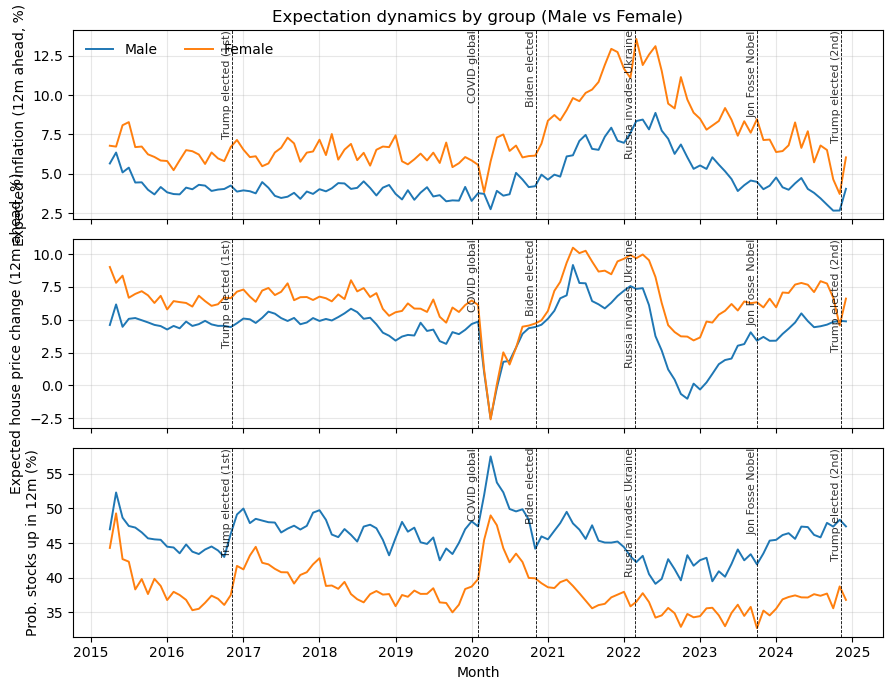

In [138]:
# A) Gender: 0 = male, 1 = female  (use your own labels if needed)
infl_f, house_f, stock_f = monthly_group_means(df, "female")
fig_f, axes_f = plot_expectation_dynamics(
    infl_f, house_f, stock_f,
    group_labels={0: "Male", 1: "Female"},
    title_suffix="(Male vs Female)"
)

## Part 5

### 5.1.1 + 5.1.2

In [139]:
def compute_merge_inflation(cpi_data, infl_gender):
    '''
    Merges inflation data with gendered expected inflation

    Parameters:
    - cpi_data: DataFrame with CPI data
    - infl_gender: DataFrame with gendered expected inflation data

    Returns:
    - Merged DataFrame with expected and future and past realized inflation
    '''
    
    # Make a copy of cpi_data, cpi_idx to avoid modifying the original DataFrame
    # Prepare CPI series with datetime monthly index
    cpi_idx = cpi_data.copy()
    cpi_idx['DATE'] = pd.to_datetime(cpi_idx['DATE'])
    cpi_idx = cpi_idx.set_index('DATE').sort_index()
    cpi_idx.index = cpi_idx.index.to_period('M').to_timestamp()

    # Forward-looking and backward-looking 12-month inflation
    cpi_idx['inflation_forward_12m'] = (cpi_idx['CPI'].shift(-12) - cpi_idx['CPI']) / cpi_idx['CPI'] * 100
    cpi_idx['inflation_backward_12m'] = (cpi_idx['CPI'] - cpi_idx['CPI'].shift(12)) / cpi_idx['CPI'].shift(12) * 100
    
    # Restrict to the analysis window, and only relevant data to prepare for merge
    cpi_fw = cpi_idx.loc['2015-01':'2024-12', ['inflation_forward_12m', 'inflation_backward_12m']].copy()

    # Rename gender columns for clarity and merge
    merged = infl_gender.rename(columns={0.0: 'exp_infl_male', 1.0: 'exp_infl_female'})
    return merged.join(cpi_fw, how='inner')

# Store merged DataFrame based on CPI and gendered expected inflation
cpi_gender = compute_merge_inflation(cpi, infl_f)
cpi_gender


,exp_infl_male,exp_infl_female,inflation_forward_12m,inflation_backward_12m
2015-04-01,5.652381,6.780556,1.185436,-0.126850
2015-05-01,6.348507,6.725000,1.097046,0.042212
2015-06-01,5.082990,8.083133,1.051746,0.210793
2015-07-01,5.388933,8.281395,0.882353,0.210526
2015-08-01,4.441356,6.692032,1.050420,0.210526
...,...,...,...,...
2024-08-01,3.437044,6.796481,2.960840,2.613525
2024-09-01,3.034840,6.508769,NaN,2.439818
2024-10-01,2.655388,4.644612,NaN,2.567436
2024-11-01,2.663529,3.714314,NaN,2.693931


### 5.1.3

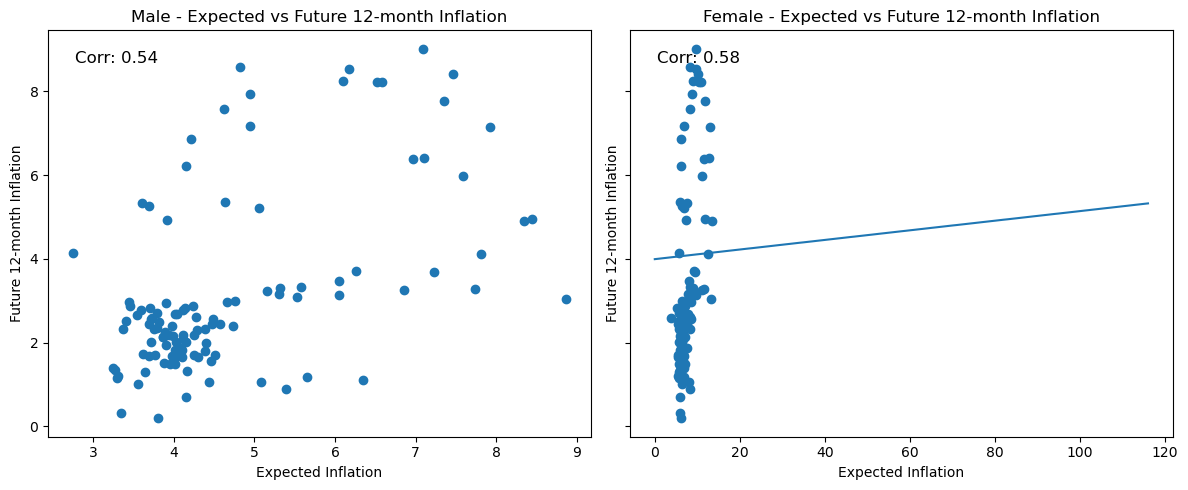

In [149]:
def plot_inflation_correlation(data, inflation_type='forward'):
    """
    Creates scatter plots comparing expected vs realized inflation by gender.
    
    Parameters:
    - data: DataFrame containing expected and realized inflation data
    - inflation_type: 'forward' or 'backward' to select inflation measure
    
    Returns:
    - figure and axes objects
    """

    # Determine the correct inflation column and labels
    inflation_col = f'inflation_{inflation_type}_12m'
    time_label = 'Future' if inflation_type == 'forward' else 'Past'
    
    # Create two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Plot for each gender with x equal to gender specific expected inflation and y equal to realized inflation
    for i, gender in enumerate(['male', 'female']):
        ax = axes[i]
        x = data[f'exp_infl_{gender}']
        y = data[inflation_col]
        
        #Making scatter plot and set titles and labels
        ax.scatter(x, y)
        ax.set_title(f'{gender.capitalize()} - Expected vs {time_label} 12-month Inflation')
        ax.set_xlabel('Expected Inflation')
        ax.set_ylabel(f'{time_label} 12-month Inflation')
        
        # Add correlation coefficient
        corr = x.corr(y)
        ax.text(0.05, 0.95, f'Corr: {corr:.2f}', 
                transform=ax.transAxes, 
                fontsize=12, 
                verticalalignment='top')
        
    slope, intercept = np.polyfit(cpi_gender.index.astype(int), cpi_gender['exp_infl_male'], 1)
    line = slope * cpi_gender.index.astype(int) + intercept
    plt.plot(line)

    plt.tight_layout()
    return fig, axes

# Plotting for forward-looking inflation
fig, axes = plot_inflation_correlation(cpi_gender, inflation_type='forward')

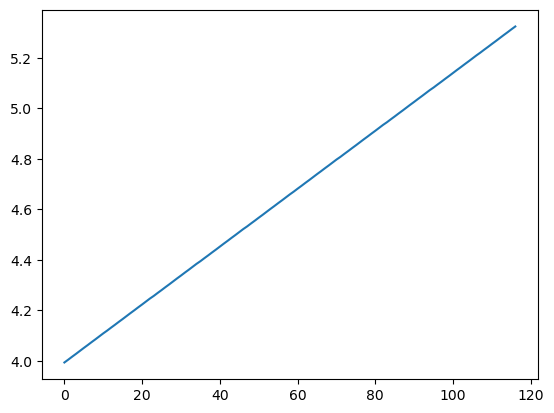

In [146]:
slope, intercept = np.polyfit(cpi_gender.index.astype(int), cpi_gender['exp_infl_male'], 1)
line = slope * cpi_gender.index.astype(int) + intercept
plt.plot(line)

### 5.2

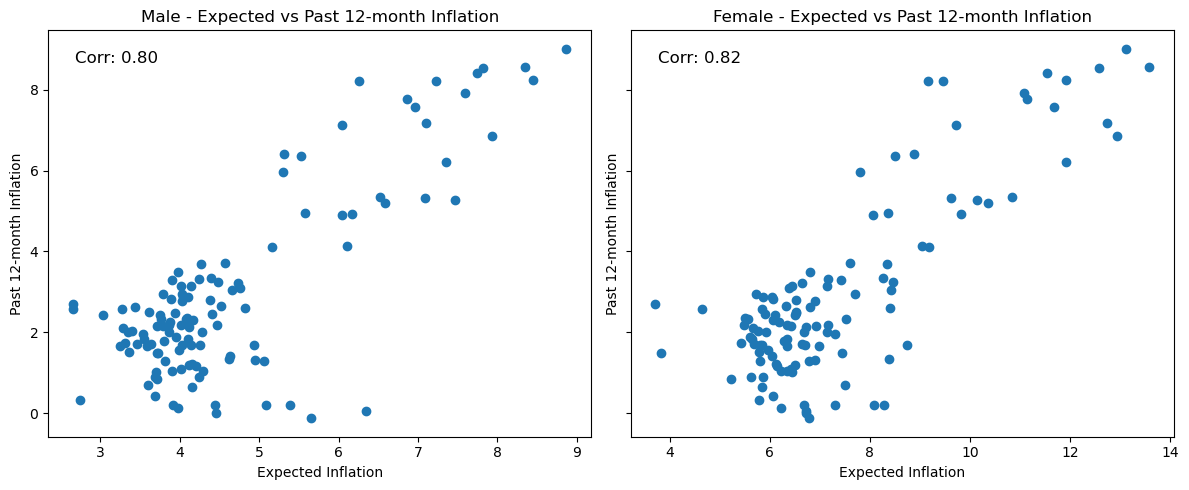

In [141]:
# Plotting for backward-looking inflation
fig, axes = plot_inflation_correlation(cpi_gender, inflation_type='backward')

These to graphs shows a significant difference in the correlation between expected inflation and future vs past inflation. The correlation between future and expected inflation is weak, with an average correlation coefficient of 0.56, especially compared to expected vs past inflation with an average of 0.81. This shows that peoples expected inflation rate is highly influenced by the past inflation, and an educated guess for the future inflation is hard to get right. 
Despite this we also see a small difference in the correlation coefficient between men and women in both the future and past 12-month inflation, where women in both instances have a higher correlation coefficient. This means women therefore are better at guessing future inflation, but also lean somewhat more on past inflation when making their guess. 

## Sources: 
- Generative AI: used for identifying bugs and suggested correction

## 